In [1]:
import logging
import pickle
from datetime import timedelta
from os.path import join as pjoin

import pandas as pd
import sys
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from features.client import make_client_features
from features.product import make_product_features
from features.purchase import (
    make_purchase_features,
    make_purchase_features_for_last_days,
)
from load_and_prepare import (
    prepare_clients,
    prepare_products,
    prepare_purchases,
    load_train,
    load_test,
)
from models.fit_predict import uplift_fit, uplift_predict
from models.metrics import uplift_metrics
from config import RANDOM_STATE, SUBMISSIONS_PATH
from models.utils import get_feature_importances
import numpy as np 
from uplift.metrics import qini_auc_score
log_format = '[%(asctime)s] %(name)-25s %(levelname)-8s %(message)s'
logging.basicConfig(
    format=log_format,
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

import torch

from pprint import pprint
from sklearn.model_selection import ParameterGrid

from uplift.metrics import uplift_at_k
from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):
    

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
    

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
    

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [63]:
def uplift_feval(preds, train_data):
    """ custom eval metric for lightGBM"""
    W = treatment_valid
    Y = target_valid
    return 'uplift', uplift_at_k(Y, preds, W), True 

In [3]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
from uplift.models import OneModel

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

eval_set = [(np.column_stack((X_valid,treatment_valid)), target_valid)]



[2021-02-17 01:55:57,087] __main__                  INFO     Loading features...
[2021-02-17 01:56:08,637] __main__                  INFO     Features are loaded
[2021-02-17 01:56:08,639] __main__                  INFO     Features shape: (400162, 334)
[2021-02-17 01:56:08,640] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-17 01:56:50,523] __main__                  INFO     Data sets prepared


ModuleNotFoundError: No module named 'tabnet'

In [32]:
X_train = X_learn
T_train =
clf.fit(
    X_train=X_learn,T_train=treatment_learn, y_train=target_learn,
    eval_set=[(X_valid, treatment_valid, target_valid)],
    eval_name=['train'],
    eval_metric=['auc'],
    max_epochs=10 , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
) 

TypeError: fit() got an unexpected keyword argument 'T_train'

## Одна модель

### Tune

In [42]:
from uplift.models import OneModel

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

eval_set = [(np.column_stack((X_valid,treatment_valid)), target_valid)]



[2021-02-15 18:34:58,504] __main__                  INFO     Loading features...
[2021-02-15 18:35:10,472] __main__                  INFO     Features are loaded
[2021-02-15 18:35:10,474] __main__                  INFO     Features shape: (400162, 334)
[2021-02-15 18:35:10,475] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-15 18:35:52,707] __main__                  INFO     Data sets prepared


In [69]:
import lightgbm as lgb



base_params = {
    'boosting_type':'rf',
    'num_leaves':40,
    'max_depth':3,
    'max_bin':110,
    # reg_lambda=1,
    'learning_rate':0.001,
    'random_state':12,
    'n_jobs':-1,
    'bagging_freq':1,
    'bagging_fraction':0.5,
    'importance_type':'split',
    'is_unbalance':True,
    'min_child_samples':20,
    'min_child_weight':0.001,
    'min_split_gain':0.0,
    'objective':'binary',
    'reg_alpha':0.0,
    'reg_lambda':0.0,
    'silent':True,
    'subsample':1.0,
    'subsample_freq':0
}


evals_result = {}

lgb_train = lgb.Dataset(np.column_stack((X_learn,treatment_learn)), label=target_learn)

lgb_valid = lgb.Dataset(np.column_stack((X_valid,treatment_valid)), label=target_valid)
clf = lgb.train(base_params,train_set = lgb_train, 
                    num_boost_round = 15000, 
                    valid_sets = [lgb_valid], 
                    verbose_eval = 10,
                    feval = uplift_feval,
                evals_result=evals_result
               )

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 86710, number of negative: 53314
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.682762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29923
[LightGBM] [Info] Number of data points in the train set: 140024, number 

[980]	valid_0's binary_logloss: 0.581504	valid_0's uplift: 0.00921047
[990]	valid_0's binary_logloss: 0.581516	valid_0's uplift: 0.00909895
[1000]	valid_0's binary_logloss: 0.581524	valid_0's uplift: 0.00954333
[1010]	valid_0's binary_logloss: 0.581545	valid_0's uplift: 0.00943436
[1020]	valid_0's binary_logloss: 0.581551	valid_0's uplift: 0.00965655
[1030]	valid_0's binary_logloss: 0.581551	valid_0's uplift: 0.00954503
[1040]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00932284
[1050]	valid_0's binary_logloss: 0.581566	valid_0's uplift: 0.00976637
[1060]	valid_0's binary_logloss: 0.581568	valid_0's uplift: 0.0096557
[1070]	valid_0's binary_logloss: 0.581569	valid_0's uplift: 0.00976722
[1080]	valid_0's binary_logloss: 0.58157	valid_0's uplift: 0.00954588
[1090]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00999026
[1100]	valid_0's binary_logloss: 0.581562	valid_0's uplift: 0.00998941
[1110]	valid_0's binary_logloss: 0.581551	valid_0's uplift: 0.00987789
[1120]	val

[2150]	valid_0's binary_logloss: 0.581614	valid_0's uplift: 0.00987533
[2160]	valid_0's binary_logloss: 0.581617	valid_0's uplift: 0.00998685
[2170]	valid_0's binary_logloss: 0.58161	valid_0's uplift: 0.00998685
[2180]	valid_0's binary_logloss: 0.581608	valid_0's uplift: 0.00987533
[2190]	valid_0's binary_logloss: 0.581604	valid_0's uplift: 0.00998685
[2200]	valid_0's binary_logloss: 0.581607	valid_0's uplift: 0.00998685
[2210]	valid_0's binary_logloss: 0.581604	valid_0's uplift: 0.00998685
[2220]	valid_0's binary_logloss: 0.581607	valid_0's uplift: 0.0102099
[2230]	valid_0's binary_logloss: 0.581614	valid_0's uplift: 0.0102099
[2240]	valid_0's binary_logloss: 0.581613	valid_0's uplift: 0.0103206
[2250]	valid_0's binary_logloss: 0.581608	valid_0's uplift: 0.0103206
[2260]	valid_0's binary_logloss: 0.581603	valid_0's uplift: 0.0103206
[2270]	valid_0's binary_logloss: 0.581597	valid_0's uplift: 0.010209
[2280]	valid_0's binary_logloss: 0.581602	valid_0's uplift: 0.010209
[2290]	valid_0's

[3320]	valid_0's binary_logloss: 0.58155	valid_0's uplift: 0.00987619
[3330]	valid_0's binary_logloss: 0.581547	valid_0's uplift: 0.00987619
[3340]	valid_0's binary_logloss: 0.581544	valid_0's uplift: 0.00987619
[3350]	valid_0's binary_logloss: 0.581539	valid_0's uplift: 0.00987619
[3360]	valid_0's binary_logloss: 0.581537	valid_0's uplift: 0.00987619
[3370]	valid_0's binary_logloss: 0.581534	valid_0's uplift: 0.00987619
[3380]	valid_0's binary_logloss: 0.581533	valid_0's uplift: 0.00987619
[3390]	valid_0's binary_logloss: 0.581536	valid_0's uplift: 0.00987619
[3400]	valid_0's binary_logloss: 0.581538	valid_0's uplift: 0.00987619
[3410]	valid_0's binary_logloss: 0.581539	valid_0's uplift: 0.00987619
[3420]	valid_0's binary_logloss: 0.581538	valid_0's uplift: 0.00987619
[3430]	valid_0's binary_logloss: 0.581538	valid_0's uplift: 0.00998685
[3440]	valid_0's binary_logloss: 0.581536	valid_0's uplift: 0.00998685
[3450]	valid_0's binary_logloss: 0.581533	valid_0's uplift: 0.00998685
[3460]	

[4480]	valid_0's binary_logloss: 0.581519	valid_0's uplift: 0.00954333
[4490]	valid_0's binary_logloss: 0.581519	valid_0's uplift: 0.00954333
[4500]	valid_0's binary_logloss: 0.58152	valid_0's uplift: 0.00954333
[4510]	valid_0's binary_logloss: 0.581519	valid_0's uplift: 0.00954333
[4520]	valid_0's binary_logloss: 0.581524	valid_0's uplift: 0.00954333
[4530]	valid_0's binary_logloss: 0.581527	valid_0's uplift: 0.00954333
[4540]	valid_0's binary_logloss: 0.581525	valid_0's uplift: 0.00954333
[4550]	valid_0's binary_logloss: 0.581525	valid_0's uplift: 0.00954333
[4560]	valid_0's binary_logloss: 0.581522	valid_0's uplift: 0.00954333
[4570]	valid_0's binary_logloss: 0.581525	valid_0's uplift: 0.00954333
[4580]	valid_0's binary_logloss: 0.581526	valid_0's uplift: 0.00954333
[4590]	valid_0's binary_logloss: 0.581523	valid_0's uplift: 0.00954333
[4600]	valid_0's binary_logloss: 0.581523	valid_0's uplift: 0.00954333
[4610]	valid_0's binary_logloss: 0.581526	valid_0's uplift: 0.00954333
[4620]	

[5640]	valid_0's binary_logloss: 0.581509	valid_0's uplift: 0.00965485
[5650]	valid_0's binary_logloss: 0.581505	valid_0's uplift: 0.00965485
[5660]	valid_0's binary_logloss: 0.581505	valid_0's uplift: 0.00965485
[5670]	valid_0's binary_logloss: 0.581506	valid_0's uplift: 0.00965485
[5680]	valid_0's binary_logloss: 0.581507	valid_0's uplift: 0.00965485
[5690]	valid_0's binary_logloss: 0.581506	valid_0's uplift: 0.00965485
[5700]	valid_0's binary_logloss: 0.581505	valid_0's uplift: 0.00965485
[5710]	valid_0's binary_logloss: 0.581507	valid_0's uplift: 0.00965485
[5720]	valid_0's binary_logloss: 0.581507	valid_0's uplift: 0.00965485
[5730]	valid_0's binary_logloss: 0.581508	valid_0's uplift: 0.00965485
[5740]	valid_0's binary_logloss: 0.581506	valid_0's uplift: 0.00965485
[5750]	valid_0's binary_logloss: 0.581504	valid_0's uplift: 0.00965485
[5760]	valid_0's binary_logloss: 0.581504	valid_0's uplift: 0.00965485
[5770]	valid_0's binary_logloss: 0.581503	valid_0's uplift: 0.00965485
[5780]

[6820]	valid_0's binary_logloss: 0.581503	valid_0's uplift: 0.009654
[6830]	valid_0's binary_logloss: 0.581504	valid_0's uplift: 0.009654
[6840]	valid_0's binary_logloss: 0.581508	valid_0's uplift: 0.009654
[6850]	valid_0's binary_logloss: 0.581507	valid_0's uplift: 0.009654
[6860]	valid_0's binary_logloss: 0.581508	valid_0's uplift: 0.009654
[6870]	valid_0's binary_logloss: 0.581511	valid_0's uplift: 0.009654
[6880]	valid_0's binary_logloss: 0.581511	valid_0's uplift: 0.009654
[6890]	valid_0's binary_logloss: 0.581511	valid_0's uplift: 0.009654
[6900]	valid_0's binary_logloss: 0.58151	valid_0's uplift: 0.009654
[6910]	valid_0's binary_logloss: 0.581511	valid_0's uplift: 0.009654
[6920]	valid_0's binary_logloss: 0.581513	valid_0's uplift: 0.009654
[6930]	valid_0's binary_logloss: 0.581513	valid_0's uplift: 0.009654
[6940]	valid_0's binary_logloss: 0.581512	valid_0's uplift: 0.009654
[6950]	valid_0's binary_logloss: 0.581512	valid_0's uplift: 0.009654
[6960]	valid_0's binary_logloss: 0.

[8010]	valid_0's binary_logloss: 0.581528	valid_0's uplift: 0.009654
[8020]	valid_0's binary_logloss: 0.581528	valid_0's uplift: 0.009654
[8030]	valid_0's binary_logloss: 0.58153	valid_0's uplift: 0.009654
[8040]	valid_0's binary_logloss: 0.581531	valid_0's uplift: 0.009654
[8050]	valid_0's binary_logloss: 0.58153	valid_0's uplift: 0.009654
[8060]	valid_0's binary_logloss: 0.58153	valid_0's uplift: 0.009654
[8070]	valid_0's binary_logloss: 0.58153	valid_0's uplift: 0.009654
[8080]	valid_0's binary_logloss: 0.581531	valid_0's uplift: 0.009654
[8090]	valid_0's binary_logloss: 0.58153	valid_0's uplift: 0.00954248
[8100]	valid_0's binary_logloss: 0.581529	valid_0's uplift: 0.009654
[8110]	valid_0's binary_logloss: 0.581529	valid_0's uplift: 0.00954248
[8120]	valid_0's binary_logloss: 0.58153	valid_0's uplift: 0.009654
[8130]	valid_0's binary_logloss: 0.581531	valid_0's uplift: 0.00954248
[8140]	valid_0's binary_logloss: 0.581532	valid_0's uplift: 0.00954248
[8150]	valid_0's binary_logloss:

[9180]	valid_0's binary_logloss: 0.581544	valid_0's uplift: 0.00965315
[9190]	valid_0's binary_logloss: 0.581545	valid_0's uplift: 0.00965315
[9200]	valid_0's binary_logloss: 0.581545	valid_0's uplift: 0.00965315
[9210]	valid_0's binary_logloss: 0.581546	valid_0's uplift: 0.00965315
[9220]	valid_0's binary_logloss: 0.581547	valid_0's uplift: 0.00976467
[9230]	valid_0's binary_logloss: 0.581547	valid_0's uplift: 0.00965315
[9240]	valid_0's binary_logloss: 0.581547	valid_0's uplift: 0.00965315
[9250]	valid_0's binary_logloss: 0.581546	valid_0's uplift: 0.00965315
[9260]	valid_0's binary_logloss: 0.581545	valid_0's uplift: 0.00965315
[9270]	valid_0's binary_logloss: 0.581545	valid_0's uplift: 0.00965315
[9280]	valid_0's binary_logloss: 0.581546	valid_0's uplift: 0.00976467
[9290]	valid_0's binary_logloss: 0.581545	valid_0's uplift: 0.00976467
[9300]	valid_0's binary_logloss: 0.581547	valid_0's uplift: 0.00976467
[9310]	valid_0's binary_logloss: 0.581549	valid_0's uplift: 0.00976467
[9320]

[10340]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00976467
[10350]	valid_0's binary_logloss: 0.58156	valid_0's uplift: 0.00976467
[10360]	valid_0's binary_logloss: 0.581558	valid_0's uplift: 0.00976467
[10370]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00976467
[10380]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00976467
[10390]	valid_0's binary_logloss: 0.58156	valid_0's uplift: 0.00976467
[10400]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00976467
[10410]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00976467
[10420]	valid_0's binary_logloss: 0.58156	valid_0's uplift: 0.00976467
[10430]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00976467
[10440]	valid_0's binary_logloss: 0.581559	valid_0's uplift: 0.00987619
[10450]	valid_0's binary_logloss: 0.58156	valid_0's uplift: 0.00987619
[10460]	valid_0's binary_logloss: 0.581561	valid_0's uplift: 0.00987619
[10470]	valid_0's binary_logloss: 0.58156	valid_0's uplift: 0.009876

[11490]	valid_0's binary_logloss: 0.58158	valid_0's uplift: 0.00987619
[11500]	valid_0's binary_logloss: 0.581581	valid_0's uplift: 0.00987619
[11510]	valid_0's binary_logloss: 0.58158	valid_0's uplift: 0.00987619
[11520]	valid_0's binary_logloss: 0.581579	valid_0's uplift: 0.00987619
[11530]	valid_0's binary_logloss: 0.581579	valid_0's uplift: 0.00987619
[11540]	valid_0's binary_logloss: 0.581579	valid_0's uplift: 0.00987619
[11550]	valid_0's binary_logloss: 0.581579	valid_0's uplift: 0.00987619
[11560]	valid_0's binary_logloss: 0.581578	valid_0's uplift: 0.00987619
[11570]	valid_0's binary_logloss: 0.581578	valid_0's uplift: 0.00987619
[11580]	valid_0's binary_logloss: 0.581579	valid_0's uplift: 0.00987619
[11590]	valid_0's binary_logloss: 0.58158	valid_0's uplift: 0.00987619
[11600]	valid_0's binary_logloss: 0.58158	valid_0's uplift: 0.00987619
[11610]	valid_0's binary_logloss: 0.58158	valid_0's uplift: 0.00987619
[11620]	valid_0's binary_logloss: 0.58158	valid_0's uplift: 0.0098761

[12640]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00965315
[12650]	valid_0's binary_logloss: 0.581588	valid_0's uplift: 0.00965315
[12660]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00976467
[12670]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00976467
[12680]	valid_0's binary_logloss: 0.581586	valid_0's uplift: 0.00976467
[12690]	valid_0's binary_logloss: 0.581586	valid_0's uplift: 0.00976467
[12700]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00976467
[12710]	valid_0's binary_logloss: 0.581586	valid_0's uplift: 0.00976467
[12720]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00987619
[12730]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00987619
[12740]	valid_0's binary_logloss: 0.581587	valid_0's uplift: 0.00987619
[12750]	valid_0's binary_logloss: 0.581589	valid_0's uplift: 0.00987619
[12760]	valid_0's binary_logloss: 0.581589	valid_0's uplift: 0.00987619
[12770]	valid_0's binary_logloss: 0.58159	valid_0's uplift: 0.00

[13780]	valid_0's binary_logloss: 0.581594	valid_0's uplift: 0.00987619
[13790]	valid_0's binary_logloss: 0.581594	valid_0's uplift: 0.00987619
[13800]	valid_0's binary_logloss: 0.581595	valid_0's uplift: 0.00987619
[13810]	valid_0's binary_logloss: 0.581595	valid_0's uplift: 0.00987619
[13820]	valid_0's binary_logloss: 0.581596	valid_0's uplift: 0.00987619
[13830]	valid_0's binary_logloss: 0.581596	valid_0's uplift: 0.00987619
[13840]	valid_0's binary_logloss: 0.581597	valid_0's uplift: 0.00987619
[13850]	valid_0's binary_logloss: 0.581598	valid_0's uplift: 0.00987619
[13860]	valid_0's binary_logloss: 0.581598	valid_0's uplift: 0.00987619
[13870]	valid_0's binary_logloss: 0.581598	valid_0's uplift: 0.00987619
[13880]	valid_0's binary_logloss: 0.581599	valid_0's uplift: 0.00998771
[13890]	valid_0's binary_logloss: 0.581599	valid_0's uplift: 0.00998771
[13900]	valid_0's binary_logloss: 0.581599	valid_0's uplift: 0.00998771
[13910]	valid_0's binary_logloss: 0.581599	valid_0's uplift: 0.0

[14930]	valid_0's binary_logloss: 0.5816	valid_0's uplift: 0.00976467
[14940]	valid_0's binary_logloss: 0.581601	valid_0's uplift: 0.00976467
[14950]	valid_0's binary_logloss: 0.5816	valid_0's uplift: 0.00976467
[14960]	valid_0's binary_logloss: 0.5816	valid_0's uplift: 0.00976467
[14970]	valid_0's binary_logloss: 0.581601	valid_0's uplift: 0.00965315
[14980]	valid_0's binary_logloss: 0.5816	valid_0's uplift: 0.00965315
[14990]	valid_0's binary_logloss: 0.581599	valid_0's uplift: 0.00976467
[15000]	valid_0's binary_logloss: 0.5816	valid_0's uplift: 0.00976467


KeyError: 'training'

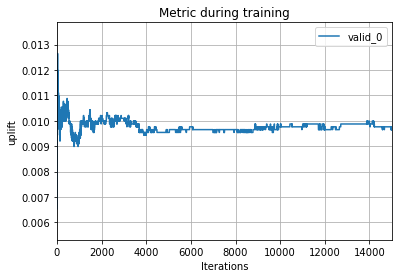

In [70]:
lgb.plot_metric(evals_result, metric='uplift');
best_iteration = 1 + np.argmax(evals_result['training']['uplift'])
print(np.max(evals_result['training']['uplift']), best_iteration)
preds = clf.predict(np.column_stack((X_valid,np.ones(X_valid.shape[0]))), num_iteration=best_iteration) - \
        clf.predict(np.column_stack((X_valid,np.zeros(X_valid.shape[0]))), num_iteration=best_iteration)

valid_scores = uplift_metrics(preds, treatment_valid, target_valid)
print(valid_scores)

In [25]:
clf_ = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=7000,
   
    max_depth=2,
  
    num_leaves = 2**2 + 100,
    learning_rate=0.001,
    
   
    
    
    objective='binary',
    
)

solo_model = OneModel(clf_)
logger.info('Build model for learn data set...')
clf = solo_model.fit(X_learn, treatment_learn, target_learn, estimator_fit_params={'early_stopping_rounds': 100,
                                                'feval':uplift_feval, "eval_set":eval_set, 'verbose':10})
logger.info('Model is ready')

valid_pred = solo_model.predict(X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-15 18:25:14,061] __main__                  INFO     Build model for learn data set...


TypeError: fit() got an unexpected keyword argument 'feval'

In [14]:
all_res_uplift = []
all_res_auqc = []

for j in range( 1, 103, 10):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
    # print(indices_valid.shape)
    # print(indices_valid_new.shape)
    # print(indices_valid_new)

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values
    #print(X_valid.info())
#     X_valid = X_valid.astype('float32')
#     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
    #print(X_valid.info())

    valid_pred = solo_model.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    #print("AUQC = ",AUQC)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

    all_res_uplift.append(valid_scores['uplift'])
    all_res_auqc.append(AUQC)

print(np.mean(all_res_auqc),np.std(all_res_auqc))
print(np.mean(all_res_uplift),np.std(all_res_uplift))

1359124.2371788365 300572.9471820077
0.0586336760388195 0.004336708525030316


### Обучение

In [15]:
from uplift.models import OneModel

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)

solo_model = OneModel(clf_)
logger.info('Build model for learn data set...')
clf = solo_model.fit(X_learn, treatment_learn, target_learn)
logger.info('Model is ready')

valid_pred = solo_model.predict(X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-24 01:13:10,394] __main__                  INFO     Loading features...
[2021-02-24 01:13:10,859] __main__                  INFO     Features are loaded
[2021-02-24 01:13:10,860] __main__                  INFO     Features shape: (400162, 334)
[2021-02-24 01:13:10,861] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-24 01:13:53,119] __main__                  INFO     Data sets prepared
[2021-02-24 01:13:53,121] __main__                  INFO     Build model for learn data set...


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[2021-02-24 01:23:10,880] __main__                  INFO     Model is ready
[2021-02-24 01:24:20,184] __main__                  INFO     Valid scores: {'roc_auc': 0.5222306168919095, 'uplift': 0.0675094869768168}


auqc 15072293.53193155


In [19]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = solo_model.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank c

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Число замеров 100
AUQC: mean:  1837281.4216883658 | std:  340124.3670261811
uplift30%: mean:  0.06735907380777079 | std:  0.009485049200163742
Kendall_rank_correlation: mean:  0.4044444444444445 | std:  0.15499337245323422
AUUC: mean:  0.027784730463518835 | std:  0.005407882486308979


In [ ]:
1711825.3675582204 0.0
0.06694298128688277 0.004427872042840285

## Трансформация классов

In [4]:
logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12
# TODO: Instead of this do cross validation and grid search
indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)

logger.info('Build model for learn data set...')
clf = uplift_fit(clf_, X_learn, treatment_learn, target_learn)
logger.info('Model is ready')
#learn_pred = uplift_predict(clf, X_learn)
#learn_scores = uplift_metrics(learn_pred, treatment_learn, target_learn)
#logger.info(f'Learn scores: {learn_scores}')
valid_pred = uplift_predict(clf, X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-24 13:53:05,254] __main__                  INFO     Loading features...
[2021-02-24 13:53:16,843] __main__                  INFO     Features are loaded
[2021-02-24 13:53:16,845] __main__                  INFO     Features shape: (400162, 334)
[2021-02-24 13:53:16,846] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-24 13:53:58,113] __main__                  INFO     Data sets prepared
[2021-02-24 13:53:58,114] __main__                  INFO     Build model for learn data set...


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[2021-02-24 14:02:41,159] __main__                  INFO     Model is ready
[2021-02-24 14:03:15,964] __main__                  INFO     Valid scores: {'roc_auc': 0.5247163679890785, 'uplift': 0.08393388269900948}


auqc 21171039.47616861


In [5]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = uplift_predict(clf, X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5555555555

Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  2566224.288749665 | std:  347358.45038968633
uplift30%: mean:  0.08363254051690527 | std:  0.009514490607642234
Kendall_rank_correlation: mean:  0.5662222222222223 | std:  0.14084631871988967
AUUC: mean:  0.03959717520443325 | std:  0.0054100181488315165


In [3]:
logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12
# TODO: Instead of this do cross validation and grid search
indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_ = LGBMClassifier(
    boosting_type='rf',
    n_estimators=15000,
    num_leaves=40,
    max_depth=3,
    max_bin=110,
    # reg_lambda=1,
    learning_rate=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bagging_freq=1,
    bagging_fraction=0.5,
    importance_type='split',
    is_unbalance=True,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    objective='binary',
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
)

logger.info('Build model for learn data set...')
clf = uplift_fit(clf_, X_learn, treatment_learn, target_learn)
logger.info('Model is ready')
#learn_pred = uplift_predict(clf, X_learn)
#learn_scores = uplift_metrics(learn_pred, treatment_learn, target_learn)
#logger.info(f'Learn scores: {learn_scores}')
valid_pred = uplift_predict(clf, X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-14 11:20:44,897] __main__                  INFO     Loading features...
[2021-02-14 11:20:45,550] __main__                  INFO     Features are loaded
[2021-02-14 11:20:45,551] __main__                  INFO     Features shape: (400162, 334)
[2021-02-14 11:20:45,551] __main__                  INFO     Preparing data sets...
[2021-02-14 11:20:49,274] __main__                  INFO     Data sets prepared
[2021-02-14 11:20:49,275] __main__                  INFO     Build model for learn data set...
[2021-02-14 11:32:50,734] __main__                  INFO     Model is ready
[2021-02-14 11:33:41,619] __main__                  INFO     Valid scores: {'roc_auc': 0.5252060317258468, 'uplift': 0.08641797998889533}


auqc 21652959.538065873


NameError: name 'np' is not defined

In [7]:
all_res_uplift = []
all_res_auqc = []

for j in range( 1, 103, 10):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
    # print(indices_valid.shape)
    # print(indices_valid_new.shape)
    # print(indices_valid_new)

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values
    #print(X_valid.info())
#     X_valid = X_valid.astype('float32')
#     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
    #print(X_valid.info())

    valid_pred = uplift_predict(clf, X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    #print("AUQC = ",AUQC)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

    all_res_uplift.append(valid_scores['uplift'])
    all_res_auqc.append(AUQC)

print(np.mean(AUQC),np.std(AUQC))
print(np.mean(all_res_uplift),np.std(all_res_uplift))

2292695.196929843 0.0
0.08592986876774618 0.006354803778403021


## Uplift деревья стат тест

In [3]:
from uplift.ensemble import RandomForestClassifier

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')


criterions = ["stat_test"]
min_samples_leaf = [5000]
stat_param=[1.3,1.4,2.4,3.4,4.5,5.5,6.5,7.4,8.2,8.3,8.4,9.0,10.0,15.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,100.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'stat_param':stat_param

}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)
results =[]
config = []
best_res = 0


for params in grid_list:
        
    print(params)

    clf =RandomForestClassifier(n_estimators = 15, min_samples_leaf = params['min_samples_leaf'], 
        max_features = 0.6, max_depth = None, criterion=params['criterion'], stat_param=params['stat_param'])

    
    logger.info('Build model for learn data set...')
    clf.fit(X_learn, treatment_learn, target_learn)
    logger.info('Model is ready')
     
    valid_pred = clf.predict_uplift(X_valid)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
    logger.info(f'Valid scores: {valid_scores}')

    print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

    all_res_uplift = []
    all_res_auqc = []

    for j in range( 1, 103, 10):

        #logger.info(f"Random state =:{j}")
        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
            indices_valid,
            test_size=0.35,
            random_state = RANDOM_STATE,
        )
        # print(indices_valid.shape)
        # print(indices_valid_new.shape)
        # print(indices_valid_new)

        X_valid = features.loc[indices_valid_new, :]
        treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
        target_valid = train.loc[indices_valid_new, 'target'].values
        #print(X_valid.info())
    #     X_valid = X_valid.astype('float32')
    #     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
        #print(X_valid.info())

        valid_pred = clf.predict_uplift(X_valid)
        AUQC = qini_auc_score(target_valid, valid_pred,treatment_valid)
        #print("AUQC = ",AUQC)
        valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

        all_res_uplift.append(valid_scores['uplift'])
        all_res_auqc.append(AUQC)

    print(np.mean(all_res_auqc),np.std(all_res_auqc))
    print(np.mean(all_res_uplift),np.std(all_res_uplift))

[2021-02-16 02:17:00,418] __main__                  INFO     Loading features...
[2021-02-16 02:17:11,973] __main__                  INFO     Features are loaded
[2021-02-16 02:17:11,973] __main__                  INFO     Features shape: (400162, 334)
[2021-02-16 02:17:11,973] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-16 02:18:07,174] __main__                  INFO     Data sets prepared
[2021-02-16 02:18:07,181] __main__                  INFO     Build model for learn data set...


{'criterion': ['stat_test'],
 'min_samples_leaf': [5000],
 'stat_param': [1.3,
                1.4,
                2.4,
                3.4,
                4.5,
                5.5,
                6.5,
                7.4,
                8.2,
                8.3,
                8.4,
                9.0,
                10.0,
                15.0,
                20.0,
                30.0,
                40.0,
                50.0,
                60.0,
                70.0,
                80.0,
                100.0]}
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 1.3}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:19:46,403] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:19:46,768] __main__                  INFO     Valid scores: {'roc_auc': 0.5165885254057702, 'uplift': 0.06590433181959354}


auqc 14365573.938940972


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1695661.3383198367 225341.0074661427
0.06633019712899775 0.0023880625440234086
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 1.4}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:21:28,083] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:21:28,173] __main__                  INFO     Valid scores: {'roc_auc': 0.5173406412449468, 'uplift': 0.06288305301358466}


auqc 1716029.9342563488


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1657385.6806401096 257973.13490153005
0.06163011945553385 0.007556967674484391
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 2.4}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:23:12,150] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:23:12,255] __main__                  INFO     Valid scores: {'roc_auc': 0.5155097590770042, 'uplift': 0.060913875940937334}


auqc 1585226.2790963957


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1755026.2737593986 247683.8521891854
0.06708375798851787 0.007729563746479019
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 3.4}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:24:57,455] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:24:57,586] __main__                  INFO     Valid scores: {'roc_auc': 0.5150822375674347, 'uplift': 0.06077782040851132}


auqc 1556216.9395919498


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1666062.3569897434 316930.1013300336
0.063833550607195 0.007144371539232099
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 4.5}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:26:42,573] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:26:42,715] __main__                  INFO     Valid scores: {'roc_auc': 0.5130559923565032, 'uplift': 0.05580725829054384}


auqc 1338340.457505554


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1653603.8055847527 236422.82893090835
0.06074279448627309 0.006019136036535995
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 5.5}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:28:28,461] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:28:28,564] __main__                  INFO     Valid scores: {'roc_auc': 0.5133374308135945, 'uplift': 0.06178191023781593}


auqc 1362857.1066048797


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1575261.5057256026 388314.95764906507
0.06609887647754721 0.007547402390978804
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 6.5}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:30:10,561] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:30:10,668] __main__                  INFO     Valid scores: {'roc_auc': 0.5138897616736127, 'uplift': 0.06724136523563456}


auqc 1454600.0781822912


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1816259.4980171053 233137.99336832244
0.06628470671010285 0.005374107013139464
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 7.4}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:31:52,197] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:31:52,305] __main__                  INFO     Valid scores: {'roc_auc': 0.5175435495061973, 'uplift': 0.07068719835354664}


auqc 1847758.440145189


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1777898.0628437975 236527.8862159043
0.06591281062268463 0.008629927903416762
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 8.2}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:33:41,817] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:33:41,959] __main__                  INFO     Valid scores: {'roc_auc': 0.5151260016492885, 'uplift': 0.06825815358129905}


auqc 1529456.4487977922


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1764871.8478278818 183943.06007413546
0.06826758900343305 0.00662249494606174
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 8.3}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:35:32,125] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:35:32,265] __main__                  INFO     Valid scores: {'roc_auc': 0.5139634977957567, 'uplift': 0.06305901816885584}


auqc 1386937.4473642893


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1642036.209964488 182651.22729043534
0.06747586598040033 0.0055597518233559285
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 8.4}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:37:22,558] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:37:22,659] __main__                  INFO     Valid scores: {'roc_auc': 0.5138580917322213, 'uplift': 0.0734962915797045}


auqc 1440840.3600756712


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1578439.8493329808 132218.42332125665
0.06599597048266223 0.006786908202686132
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 9.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:39:07,398] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:39:07,508] __main__                  INFO     Valid scores: {'roc_auc': 0.5099777294393506, 'uplift': 0.05681679034114567}


auqc 1004901.804579488


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1442529.598614124 255583.5067538947
0.06341901476071272 0.006938022410825843
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 10.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:40:52,674] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:40:52,803] __main__                  INFO     Valid scores: {'roc_auc': 0.5145488242311806, 'uplift': 0.06582638769840299}


auqc 1491076.4911587667


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1762430.3913174495 237557.84180933022
0.0636058627661384 0.007579361966116723
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 15.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:42:41,544] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:42:41,648] __main__                  INFO     Valid scores: {'roc_auc': 0.5111795029306454, 'uplift': 0.06388895691665508}


auqc 1108929.3426565584


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1556784.9460204 244258.52709107293
0.0645894013144003 0.00478569894413583
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 20.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:44:31,270] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:44:31,404] __main__                  INFO     Valid scores: {'roc_auc': 0.5132607210946025, 'uplift': 0.06220912460963396}


auqc 1377696.540799223


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1858400.3014530437 259120.00265886853
0.06871181827116195 0.006662818907364423
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 30.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:46:16,672] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:46:16,802] __main__                  INFO     Valid scores: {'roc_auc': 0.5112115769180205, 'uplift': 0.0602208997624471}


auqc 1149230.7438878557


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1644015.3023747823 241673.61403530647
0.0635135454103989 0.007241333935554898
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 40.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:47:58,413] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:47:58,553] __main__                  INFO     Valid scores: {'roc_auc': 0.5137604261001757, 'uplift': 0.07138198860580264}


auqc 1423627.9027378773


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1546133.8641352535 269982.76592029654
0.06945057518906862 0.008086612397317488
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 50.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:49:37,459] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:49:37,579] __main__                  INFO     Valid scores: {'roc_auc': 0.5148318107745699, 'uplift': 0.06536924110945119}


auqc 1515924.6086533684


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1800951.9615262381 183048.91262749193
0.06604059888230139 0.0073678749358302145
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 60.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:51:19,703] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:51:19,833] __main__                  INFO     Valid scores: {'roc_auc': 0.5108819298732524, 'uplift': 0.048457538428885116}


auqc 1107062.4579447713


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1453766.5991261126 228965.82393927698
0.05668780783455396 0.005588802099865309
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 70.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:53:03,137] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:53:03,266] __main__                  INFO     Valid scores: {'roc_auc': 0.5200608377031815, 'uplift': 0.06412660057995945}


auqc 2069110.6164902179


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

2034970.4049244337 213897.32058773565
0.0682462138082036 0.007734246701337789
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 80.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:54:47,536] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:54:47,633] __main__                  INFO     Valid scores: {'roc_auc': 0.5158802147661483, 'uplift': 0.06554611330160515}


auqc 1639046.5287916819


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1657981.0115281602 239678.10269945097
0.06168863501365793 0.007531002174414305
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 100.0}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:56:28,364] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-16 02:56:28,457] __main__                  INFO     Valid scores: {'roc_auc': 0.5139140316717028, 'uplift': 0.06391798209690602}


auqc 1438742.570594363


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

C:\Python38\lib\site-packages\numpy\core\_meth

1694075.2545774789 167178.95883943356
0.0665542884157298 0.005580861693346423


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce



best result: {'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 40.0}

In [11]:
from uplift.ensemble import RandomForestClassifier
from uplift.metrics import Kendall_rank_correlation
from uplift.metrics import uplift_at_k
from uplift.metrics import qini_auc_score
logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')


criterions = ["stat_test"]
min_samples_leaf = [5000]
stat_param=[40.0]
param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf,
        'stat_param':stat_param

}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)
results =[]
config = []
best_res = 0


for params in grid_list:
        
    print(params)

    clf =RandomForestClassifier(n_estimators = 30, min_samples_leaf = params['min_samples_leaf'], 
        max_features = 1.0, max_depth = None, criterion=params['criterion'], stat_param=params['stat_param'])

    
    logger.info('Build model for learn data set...')
    clf.fit(X_learn, treatment_learn, target_learn)
    logger.info('Model is ready')
     
    valid_pred = clf.predict_uplift(X_valid)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
    logger.info(f'Valid scores: {valid_scores}')

    print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

    all_res_uplift = []
    all_res_auqc = []






[2021-02-25 02:12:39,107] __main__                  INFO     Loading features...
[2021-02-25 02:12:39,566] __main__                  INFO     Features are loaded
[2021-02-25 02:12:39,566] __main__                  INFO     Features shape: (400162, 334)
[2021-02-25 02:12:39,566] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-25 02:13:22,237] __main__                  INFO     Data sets prepared
[2021-02-25 02:13:22,239] __main__                  INFO     Build model for learn data set...


{'criterion': ['stat_test'], 'min_samples_leaf': [5000], 'stat_param': [40.0]}
{'criterion': 'stat_test', 'min_samples_leaf': 5000, 'stat_param': 40.0}


[2021-02-25 02:18:16,958] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-25 02:18:17,304] __main__                  INFO     Valid scores: {'roc_auc': 0.5175795136048025, 'uplift': 0.06445975512099772}


auqc 15116938.988301992


In [12]:
all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = clf.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc, ddof=1))


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce



Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.64444444444

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Число замеров 100
AUQC: mean:  1826565.3895536233 | std:  314267.31295718567
uplift30%: mean:  0.06471138797970856 | std:  0.010590769072171156
Kendall_rank_correlation: mean:  0.5817777777777777 | std:  0.12444684942361045
AUUC: mean:  0.029280129466266347 | std:  0.00506992700881844


In [21]:
all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = clf.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc, ddof=1))


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce



Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift r

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Число замеров 100
AUQC: mean:  1625416.8048548354 | std:  314099.34861221194
uplift30%: mean:  0.06362392315007119 | std:  0.010202285088420806
Kendall_rank_correlation: mean:  0.5684444444444444 | std:  0.13930438412103566
AUUC: mean:  0.025930629657558994 | std:  0.005115079171197111


Число замеров 100
AUQC: mean:  1760979.68762225 | std:  307641.1237836408
uplift30%: mean:  0.07126378377337372 | std:  0.010898862493769233
Kendall_rank_correlation: mean:  0.5222222222222223 | std:  0.13758648608153115

## Две независимые модели

In [22]:
from uplift.models import TwoModels

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=20,
    max_depth=2,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =2,
            learning_rate= 0.2,
            n_estimators = 100,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_independent')
logger.info('Build model for learn data set...')
clf = model_two.fit(X_learn, treatment_learn, target_learn)
logger.info('Model is ready')

valid_pred = model_two.predict(X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-24 02:15:58,003] __main__                  INFO     Loading features...
[2021-02-24 02:15:58,523] __main__                  INFO     Features are loaded
[2021-02-24 02:15:58,524] __main__                  INFO     Features shape: (400162, 334)
[2021-02-24 02:15:58,525] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-24 02:16:42,735] __main__                  INFO     Data sets prepared
[2021-02-24 02:16:42,736] __main__                  INFO     Build model for learn data set...
[2021-02-24 02:17:20,989] __main__                  INFO     Model is ready
[2021-02-24 02:17:22,707] __main__                  INFO     Valid scores: {'roc_auc': 0.5234025528854738, 'uplift': 0.07289062403965785}


auqc 17686664.958799668


In [23]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.55555

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  2193889.6133197746 | std:  310083.8447777294
uplift30%: mean:  0.07425452931349696 | std:  0.009088030281677636
Kendall_rank_correlation: mean:  0.6266666666666667 | std:  0.13811117837892814
AUUC: mean:  0.03319953457766392 | std:  0.0048942654786226746


In [24]:
all_res_uplift = []
all_res_auqc = []

for j in range( 1, 103, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
    # print(indices_valid.shape)
    # print(indices_valid_new.shape)
    # print(indices_valid_new)

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values
    #print(X_valid.info())
#     X_valid = X_valid.astype('float32')
#     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
    #print(X_valid.info())

    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    #print("AUQC = ",AUQC)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

    all_res_uplift.append(valid_scores['uplift'])
    all_res_auqc.append(AUQC)

print(np.mean(AUQC),np.std(AUQC))
print(np.mean(all_res_uplift),np.std(all_res_uplift))

2032036.4980179071 0.0
0.071493804197752 0.006895689461895756


## Две зависимые модели treatment, control

In [24]:
from uplift.models import TwoModels

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=20,
    max_depth=2,
    learning_rate=0.5,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =2,
            learning_rate= 0.2,
            n_estimators = 100,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_dependent_treatment')
logger.info('Build model for learn data set...')
clf = model_two.fit(X_learn, treatment_learn, target_learn)
logger.info('Model is ready')

valid_pred = model_two.predict(X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-24 02:18:42,241] __main__                  INFO     Loading features...
[2021-02-24 02:18:42,798] __main__                  INFO     Features are loaded
[2021-02-24 02:18:42,799] __main__                  INFO     Features shape: (400162, 334)
[2021-02-24 02:18:42,801] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-24 02:19:24,982] __main__                  INFO     Data sets prepared
[2021-02-24 02:19:24,982] __main__                  INFO     Build model for learn data set...
[2021-02-24 02:20:04,046] __main__                  INFO     Model is ready
[2021-02-24 02:20:05,784] __main__                  INFO     Valid scores: {'roc_auc': 0.5229695565050191, 'uplift': 0.0729042493273625}


auqc 17490439.72332333


In [25]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6 with p

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Число замеров 100
AUQC: mean:  2167373.3722758368 | std:  317096.77339979826
uplift30%: mean:  0.07558468550477446 | std:  0.008937799293921975
Kendall_rank_correlation: mean:  0.6022222222222222 | std:  0.12812498574270173
AUUC: mean:  0.03298734268830169 | std:  0.004970351211918884


In [26]:
all_res_uplift = []
all_res_auqc = []

for j in range( 1, 103, 10):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
    # print(indices_valid.shape)
    # print(indices_valid_new.shape)
    # print(indices_valid_new)

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values
    #print(X_valid.info())
#     X_valid = X_valid.astype('float32')
#     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
    #print(X_valid.info())

    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    #print("AUQC = ",AUQC)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

    all_res_uplift.append(valid_scores['uplift'])
    all_res_auqc.append(AUQC)

print(np.mean(AUQC),np.std(AUQC))
print(np.mean(all_res_uplift),np.std(all_res_uplift))

2145354.794897791 0.0
0.07361582928383355 0.004068882306630594


## Две зависимые модели control

In [26]:
from uplift.models import TwoModels

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

clf_lgbm = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.4,
    random_state=RANDOM_STATE,
    
)

xgb_clf = XGBClassifier(max_depth =3,
            learning_rate= 0.4,
            n_estimators = 100,
            nthread =40,
            n_gpus =0,
            seed = 42)

model_two = TwoModels(estimator_trmnt = clf_lgbm, estimator_ctrl = xgb_clf, method = 'two_dependent_control')
logger.info('Build model for learn data set...')
clf = model_two.fit(X_learn, treatment_learn, target_learn)
logger.info('Model is ready')

valid_pred = model_two.predict(X_valid)
valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
logger.info(f'Valid scores: {valid_scores}')

print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-24 02:21:26,760] __main__                  INFO     Loading features...
[2021-02-24 02:21:27,226] __main__                  INFO     Features are loaded
[2021-02-24 02:21:27,228] __main__                  INFO     Features shape: (400162, 334)
[2021-02-24 02:21:27,228] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-24 02:22:10,189] __main__                  INFO     Data sets prepared
[2021-02-24 02:22:10,189] __main__                  INFO     Build model for learn data set...
[2021-02-24 02:23:04,666] __main__                  INFO     Model is ready
[2021-02-24 02:23:06,519] __main__                  INFO     Valid scores: {'roc_auc': 0.517378640886817, 'uplift': 0.07177201753929963}


auqc 13070926.6602666


In [27]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation 

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Число замеров 100
AUQC: mean:  1638214.0614593255 | std:  376316.0332890127
uplift30%: mean:  0.07228106361611725 | std:  0.010736883609712946
Kendall_rank_correlation: mean:  0.49822222222222223 | std:  0.16812100227339874
AUUC: mean:  0.02491492664485668 | std:  0.005975417732414677


In [28]:
all_res_uplift = []
all_res_auqc = []

for j in range( 1, 103, 10):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
    # print(indices_valid.shape)
    # print(indices_valid_new.shape)
    # print(indices_valid_new)

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values
    #print(X_valid.info())
#     X_valid = X_valid.astype('float32')
#     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
    #print(X_valid.info())

    valid_pred = model_two.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
    #print("AUQC = ",AUQC)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

    all_res_uplift.append(valid_scores['uplift'])
    all_res_auqc.append(AUQC)

print(np.mean(AUQC),np.std(AUQC))
print(np.mean(all_res_uplift),np.std(all_res_uplift))

1718610.1551068537 0.0
0.07195902512184928 0.010031946237963859


## Uplift деревья

In [28]:
from uplift.ensemble import RandomForestClassifier

logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')


criterions = ["uplift_gini"]
min_samples_leaf = [6500]

param_grid = {
        'criterion':criterions,
        'min_samples_leaf':min_samples_leaf

}

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

pprint(param_grid)
results =[]
config = []
best_res = 0


for params in grid_list:
        
    print(params)

    clf = RandomForestClassifier(n_estimators = 15, min_samples_leaf = params['min_samples_leaf'], 
        max_features = 1.0, max_depth = None, criterion=params['criterion'])

    
    logger.info('Build model for learn data set...')
    clf.fit(X_learn, treatment_learn, target_learn)
    logger.info('Model is ready')
     
    valid_pred = clf.predict_uplift(X_valid)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)
    logger.info(f'Valid scores: {valid_scores}')

    print('auqc', qini_auc_score(target_valid, valid_pred, treatment_valid))

[2021-02-24 02:24:30,622] __main__                  INFO     Loading features...
[2021-02-24 02:24:31,130] __main__                  INFO     Features are loaded
[2021-02-24 02:24:31,132] __main__                  INFO     Features shape: (400162, 334)
[2021-02-24 02:24:31,133] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-24 02:25:14,029] __main__                  INFO     Data sets prepared
[2021-02-24 02:25:14,030] __main__                  INFO     Build model for learn data set...


{'criterion': ['uplift_gini'], 'min_samples_leaf': [6500]}
{'criterion': 'uplift_gini', 'min_samples_leaf': 6500}


C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-24 02:28:20,766] __main__                  INFO     Model is ready
C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce

[2021-02-24 02:28:21,109] __main__                  INFO     Valid scores: {'roc_auc': 0.51952105470114, 'uplift': 0.06406676924138699}


auqc 13860493.080566935


In [29]:
from uplift.metrics import Kendall_rank_correlation

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values


    valid_pred = clf.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

C:\Python38\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning:

overflow encountered in reduce



Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.2888888888

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Число замеров 100
AUQC: mean:  1686188.0296252356 | std:  343677.08268744743
uplift30%: mean:  0.06537550395194038 | std:  0.00968191486938474
Kendall_rank_correlation: mean:  0.4404444444444444 | std:  0.15654264339755955
AUUC: mean:  0.025663022237826648 | std:  0.00550621145322829


In [47]:
import warnings
warnings.filterwarnings("ignore")

all_res_uplift = []
all_res_auqc = []

#random shaffle 
# тетрадки+таблицы+casualml+норм_
for j in range( 1, 101, 1):
    
    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_valid,
        test_size=0.99,
        random_state = RANDOM_STATE,
    )
    # print(indices_valid.shape)
    # print(indices_valid_new.shape)
    # print(indices_valid_new)

    X_valid = features.loc[indices_valid_new, :]
    treatment_valid = train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = train.loc[indices_valid_new, 'target'].values
    #print(X_valid.info())
#     X_valid = X_valid.astype('float32')
#     X_valid = X_valid.replace([np.inf, -np.inf], np.nan).fillna(0)
    #print(X_valid.info())

    valid_pred = clf.predict_uplift(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred,treatment_valid)
#     print("AUQC = ",AUQC)
    valid_scores = uplift_metrics(valid_pred, treatment_valid, target_valid)

    all_res_uplift.append(valid_scores['uplift'])
    all_res_auqc.append(AUQC)

print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))

Число замеров 100
AUQC: mean:  13332845.661777621 | std:  200948.91050553104
uplift30%: mean:  0.059433839239469786 | std:  0.0005818335866406218


# R learner

In [3]:
import causalml
print(causalml.__version__)

0.8.0


In [4]:
logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values
# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')

eval_set = [(np.column_stack((X_valid,treatment_valid)), target_valid)]



[2021-02-16 15:38:35,670] __main__                  INFO     Loading features...
[2021-02-16 15:38:36,212] __main__                  INFO     Features are loaded
[2021-02-16 15:38:36,212] __main__                  INFO     Features shape: (400162, 334)
[2021-02-16 15:38:36,228] __main__                  INFO     Preparing data sets...


Mem. usage decreased to 255.69 Mb (68.1% reduction)


[2021-02-16 15:39:56,237] __main__                  INFO     Data sets prepared


In [5]:
from causalml.inference.meta import LRSRegressor

learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X_learn, treatment=treatment_learn, y=target_learn)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

ModuleNotFoundError: No module named 'llvmlite.binding'